<a href="https://colab.research.google.com/github/jplimmer/leaflens/blob/master/leaflens_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Training TensorFlow model on the PlantVillage color dataset ().

# This notebook requires that the dataset has already been split into training and test sets, which are in
# zipped folders in your Google Drive (called 'train.zip' and 'test.zip' respectively).
# In Colab 'Secrets', create the secret name 'gdrive_plantvillage_path' as your Google Drive file path for
# where the training data zipped folder is located (starting with '/content/'). This is also where the model will be saved.

# The notebook uses only training and validation sets, so the model can still be tuned before final testing.

In [8]:
# Imports
import os
from google.colab import drive, userdata
drive.mount('/content/drive')
import shutil
import zipfile

import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(keras.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.17.0
3.4.1


In [9]:
# Load PlantVillage training data (zip file) from Google Drive into Colab local file system

# Define paths (see intro cell for creating a secret name in Colab)
drive_dataset_path = userdata.get('gdrive_plantvillage_path') + 'train.zip'
local_dataset_path = '/content/plants'

# Copy dataset across
shutil.copy(drive_dataset_path, '/content/')

# Extract the dataset from zip file
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall(local_dataset_path)

# Verify extraction
!ls /content/plants/train

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [10]:
# Create training and validation sets (from training data)
data_dir = '/content/plants/train'
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
class_names

Found 43429 files belonging to 38 classes.
Using 34744 files for training.
Found 43429 files belonging to 38 classes.
Using 8685 files for validation.


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [11]:
# Performance optimisation
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Define model
num_classes = len(class_names)

model = models.Sequential([
  keras.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.5333 - loss: 1.7420 - val_accuracy: 0.8325 - val_loss: 0.5338
Epoch 2/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8665 - loss: 0.4258 - val_accuracy: 0.8670 - val_loss: 0.4346
Epoch 3/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9194 - loss: 0.2415 - val_accuracy: 0.8875 - val_loss: 0.3919
Epoch 4/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9462 - loss: 0.1599 - val_accuracy: 0.8885 - val_loss: 0.4229
Epoch 5/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9539 - loss: 0.1379 - val_accuracy: 0.8850 - val_loss: 0.4493
Epoch 6/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9706 - loss: 0.0854 - val_accuracy: 0.8892 - val_loss: 0.4648
Epoch 7/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9731 - loss: 0.0819 - val_accuracy: 0.8882 - val_loss: 0.4766
Epoch 8/10
1086/1086 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9757 - loss: 0.0724 

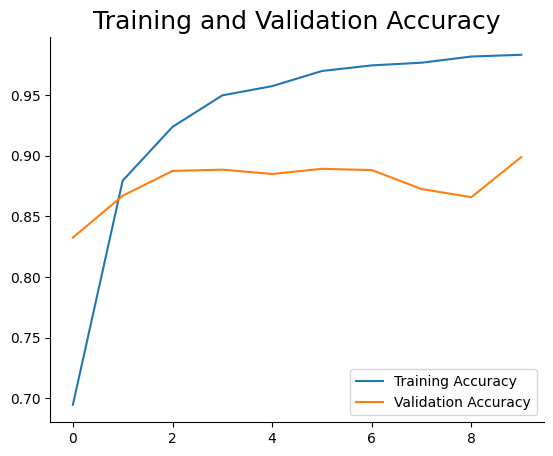

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=18)

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
sns.despine()

training_chart_path = userdata.get('gdrive_plantvillage_path') + 'training_chart.png'
plt.savefig(training_chart_path, transparent=True, bbox_inches="tight")
plt.show()

In [30]:
# Save model to Google Drive
leaflens_model_path = userdata.get('gdrive_plantvillage_path') + 'leaflens_model.keras'
model.save(leaflens_model_path)

# Check model was saved
!ls "{userdata.get('gdrive_plantvillage_path')}"

color.zip  leaflens_model.keras  plant_model.keras  test.zip  training_chart.png  train.zip


In [ ]:
## Future - convert saved model to TensorLite (for use on edge devices, rather than server?)